In [1]:
import glob
images = list(glob.glob('dataset/*.jpg'))

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from bertopic.representation import KeyBERTInspired, VisualRepresentation
from bertopic.backend import MultiModalBackend
from transformers.pipelines import Pipeline, pipeline

image_to_text_model=pipeline("image-to-text", model="nlpconnect/vit-gpt2-image-captioning", device=str(device))

# Image embedding model
embedding_model = MultiModalBackend('clip-ViT-B-32', batch_size=32)

# Image to text representation model
representation_model = {
    "Visual_Aspect": VisualRepresentation(image_to_text_model=image_to_text_model)
}


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang

In [4]:
from bertopic import BERTopic

# Train our model with images only
topic_model = BERTopic(embedding_model=embedding_model, representation_model=representation_model, min_topic_size=2)
topics, probs = topic_model.fit_transform(documents=None, images=images)


  0%|                                                                                                                                | 0/875 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 875/875 [00:18<00:00, 46.95it/s]


,Topic,Count,Representation,Visual_Aspect
0,-1,2460,"[hugging, board, surfing, bat, blue, brown, baseball, hand, his, grassy]",
1,0,102,"[stick, tongue, snow, fighting, through, collar, out, covered, ground, its]",
2,1,76,"[rail, into, catch, up, fence, leash, over, jumping, air, to]",
3,2,70,"[snowboarder, jump, mid, airborne, after, doing, trick, skier, pile, slope]",
4,3,54,"[bird, beak, long, body, flying, over, water, white, of, is]",
5,4,49,"[couch, bed, into, blanket, chair, young, animal, wooden, stuffed, catch]",
6,5,47,"[pole, air, skateboard, ramp, jumping, kite, flying, person, bike, hill]",
7,6,41,"[pool, into, surfing, air, bikini, while, jumping, catch, swimming, it]",
8,7,38,"[boat, canoe, paddle, paddling, lake, water, body, sitting, near, rock]",
9,8,36,"[guitar, drum, set, band, pants, suit, shirt, black, room, tie]",

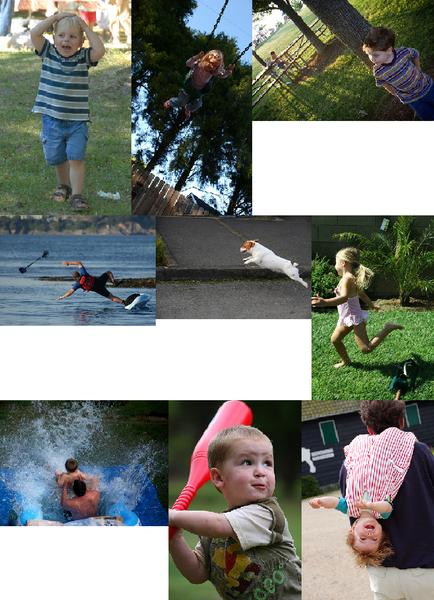
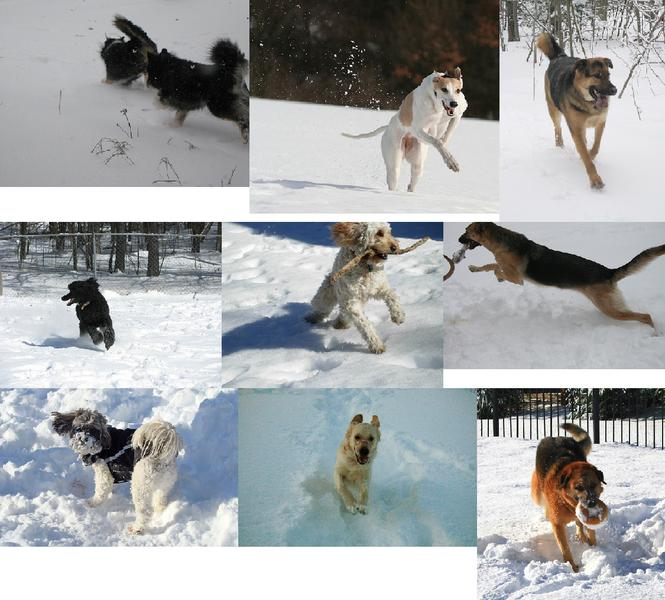
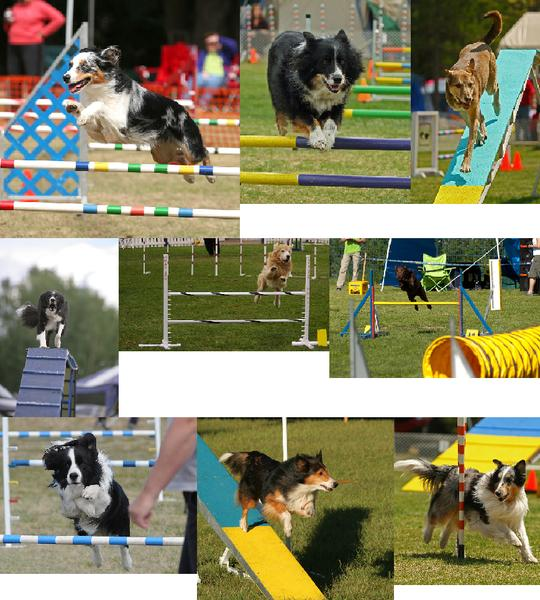
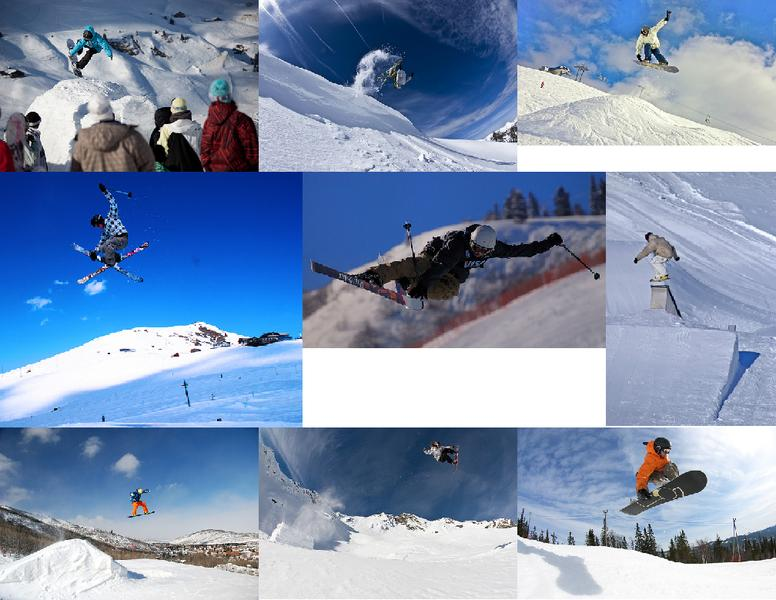
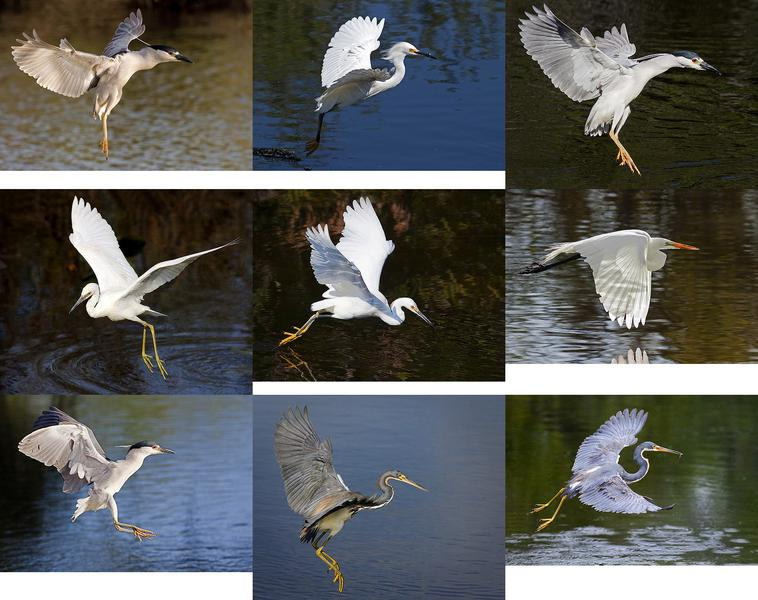
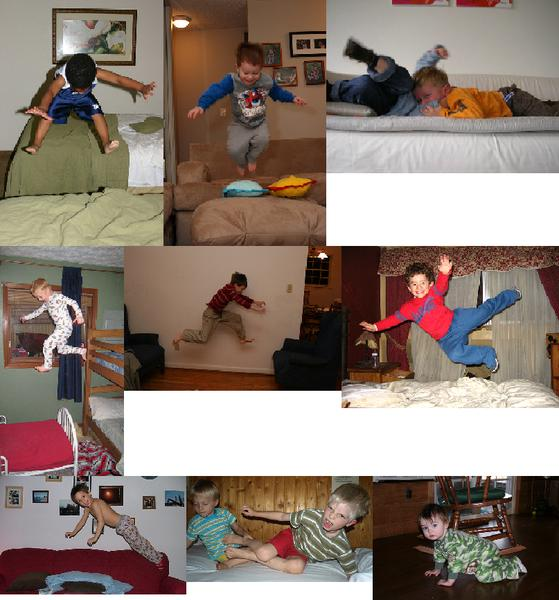
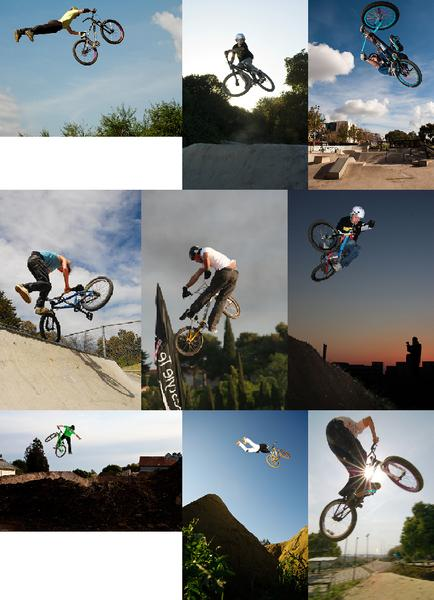
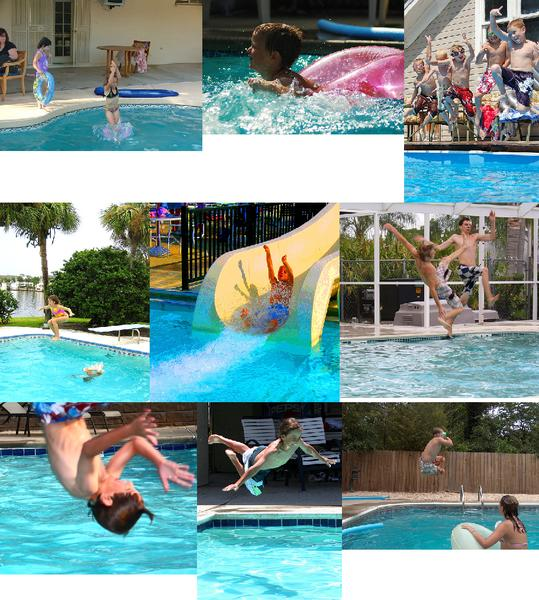
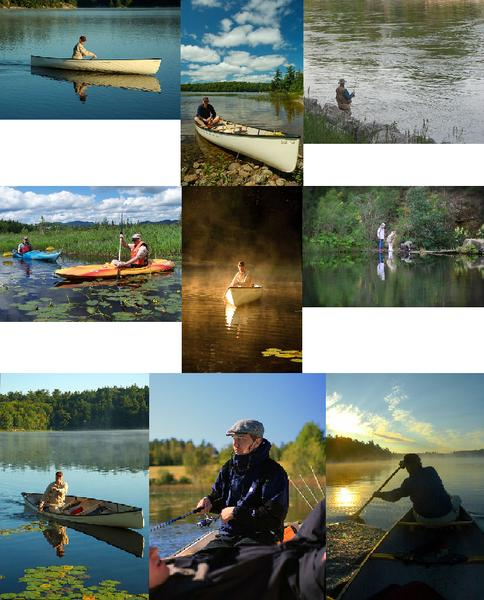
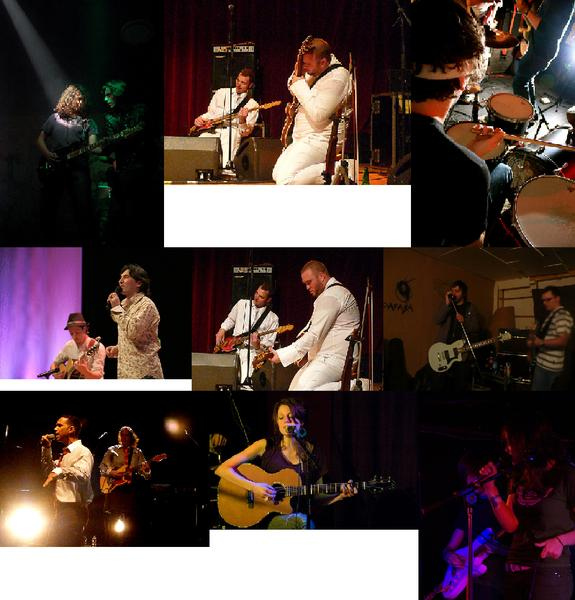
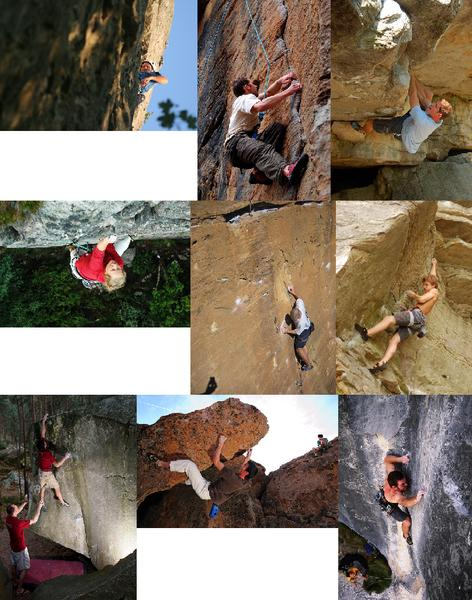
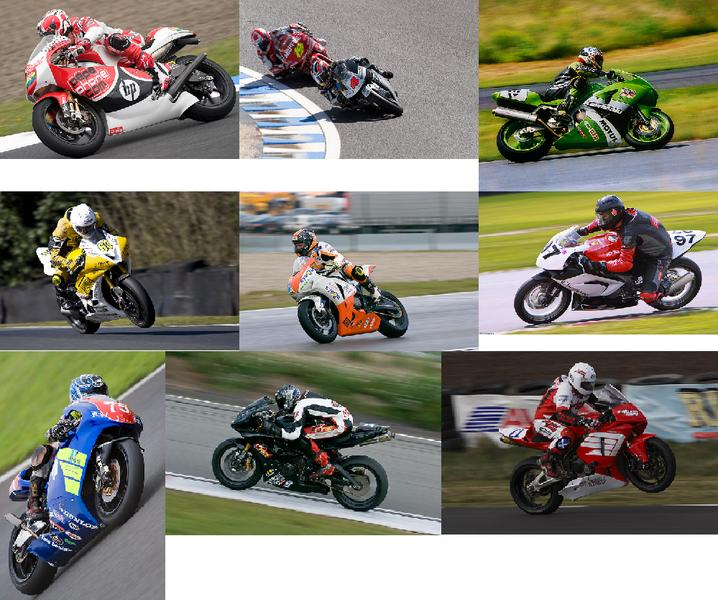
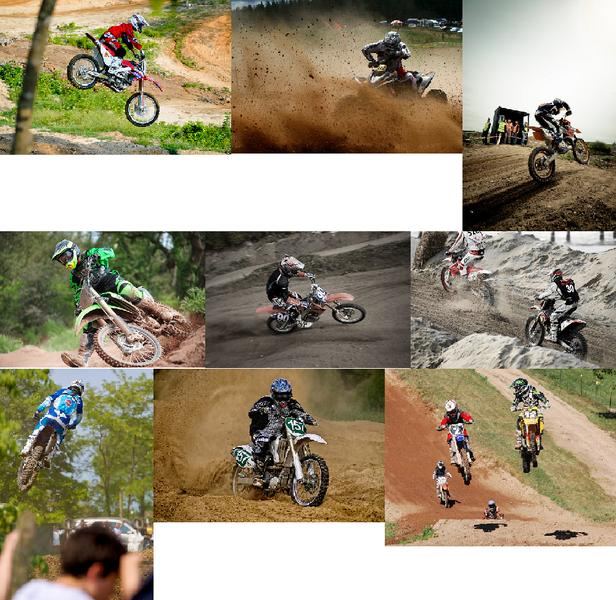
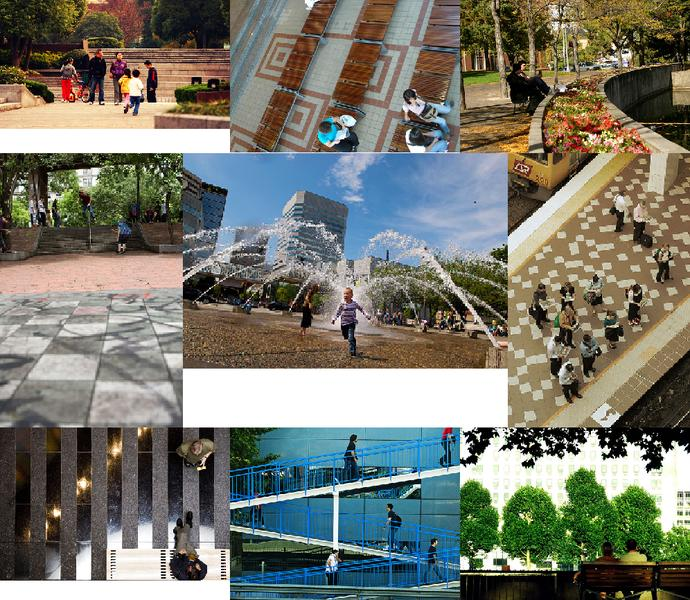
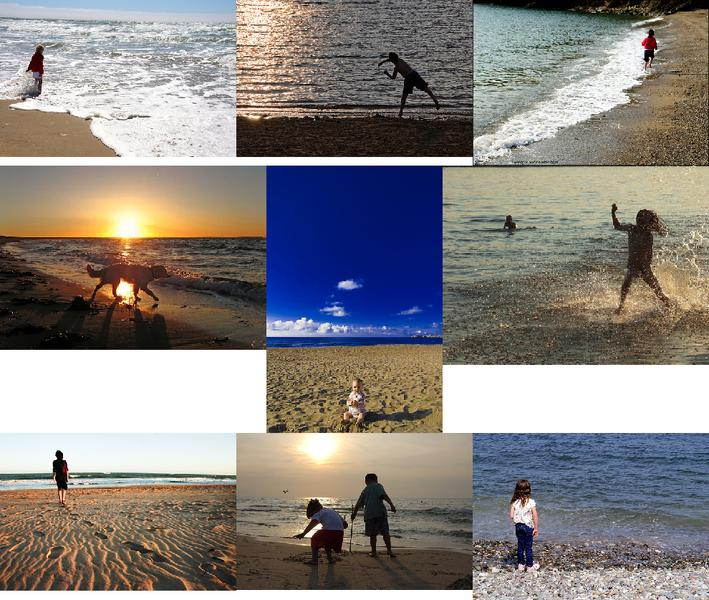
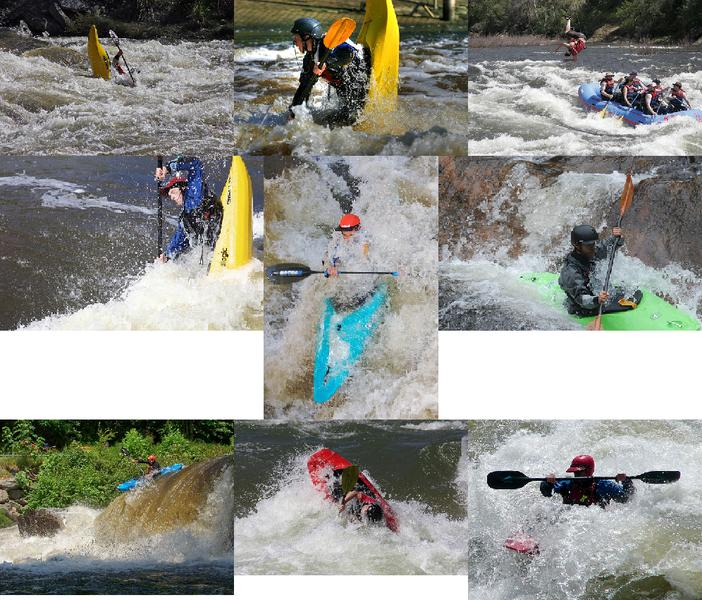
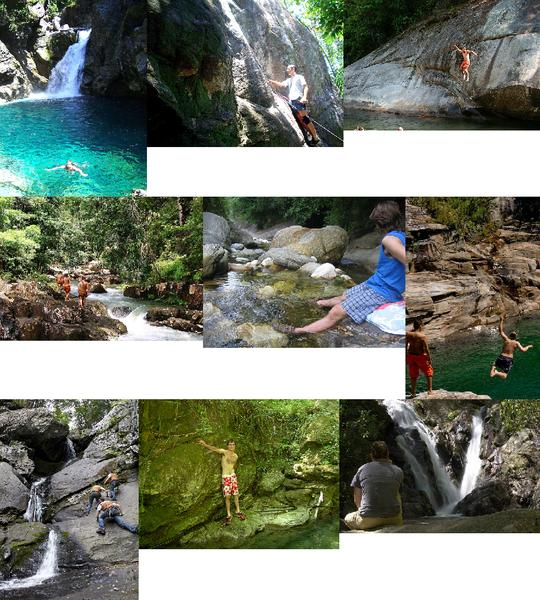
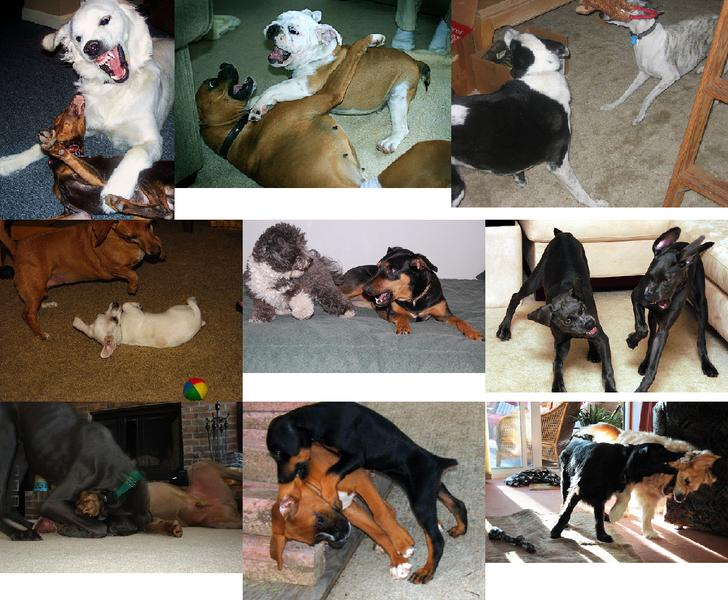
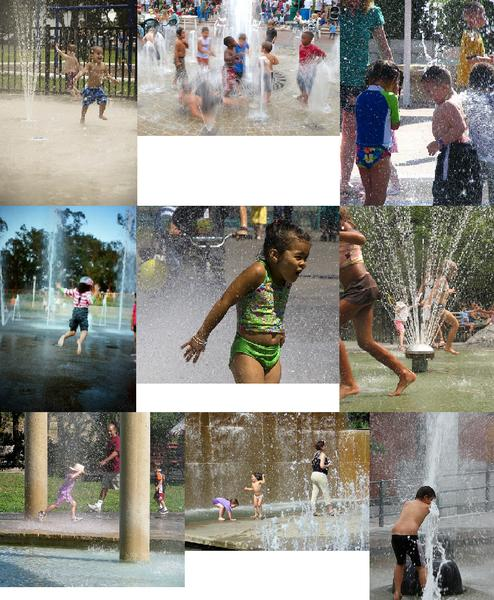
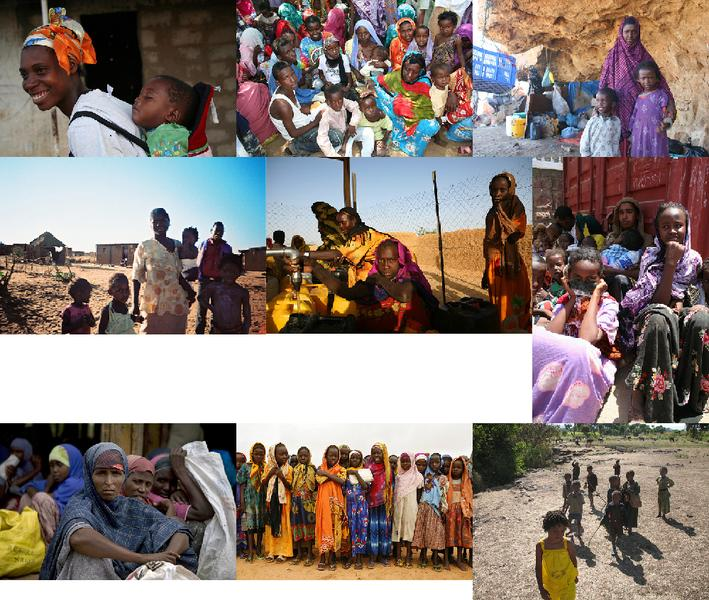

In [5]:
import base64
from io import BytesIO
from IPython.display import HTML

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

# Extract dataframe
df = topic_model.get_topic_info()
df = df.drop(columns=['Name', 'Representative_Docs'])
df_first20 = df.head(20)
# Visualize the images
HTML(df_first20.to_html(formatters={'Visual_Aspect': image_formatter}, escape=False))

In [6]:
def image_blob(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return buffer.getvalue()

df_blob = df.copy()
df_blob["Visual_Aspect"] = df_blob["Visual_Aspect"].apply(image_blob)
df_blob.head()


,Topic,Count,Representation,Visual_Aspect
0,-1,2460,"[hugging, board, surfing, bat, blue, brown, ba...",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,0,102,"[stick, tongue, snow, fighting, through, colla...",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,1,76,"[rail, into, catch, up, fence, leash, over, ju...",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,2,70,"[snowboarder, jump, mid, airborne, after, doin...",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,3,54,"[bird, beak, long, body, flying, over, water, ...",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [7]:
import sqlite3

In [8]:
conn = sqlite3.connect("finalproject.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS Topics (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    Topic INTEGER,
    Count INTEGER,
    Representation TEXT,
    Visual_Aspect BLOB
)
""")

conn.commit()

for _, row in df_blob.iterrows():
    representation_str = ', '.join(row["Representation"])
    cursor.execute("""
    INSERT INTO Topics (Topic, Count, Representation, Visual_Aspect)
    VALUES (?, ?, ?, ?)
    """, (row["Topic"], row["Count"], representation_str, row["Visual_Aspect"]))
conn.commit()
conn.close()

In [12]:
conn = sqlite3.connect('finalproject.db')
cursor = conn.cursor()

cursor.execute("SELECT Topic, Count, Representation, Visual_Aspect FROM Topics;")
rows = cursor.fetchall()
for row in rows[:20]:
    print(f"Topic: {row[0]}, Count: {row[1]}, Representation: {row[2]}, Visual_Aspect size: {len(row[3])} bytes")

conn.close()

Topic: -1, Count: 9, Representation: is, in, grass, the, blue, shirt, hugging, young, on, girl, Visual_Aspect size: 90152 bytes
Topic: 0, Count: 4051, Representation: on, in, man, with, the, dog, is, standing, of, and, Visual_Aspect size: 66721 bytes
Topic: 1, Count: 315, Representation: soccer, player, ball, baseball, is, game, man, playing, tennis, white, Visual_Aspect size: 60862 bytes
Topic: 2, Count: 6, Representation: woman, and, window, they, pose, as, smile, store, man, for, Visual_Aspect size: 119222 bytes
Topic: -1, Count: 2492, Representation: surfing, throwing, bat, board, bed, baseball, hand, doing, trick, park, Visual_Aspect size: 97877 bytes
Topic: 0, Count: 131, Representation: snow, tongue, covered, fighting, through, stick, ground, across, out, trail, Visual_Aspect size: 70820 bytes
Topic: 1, Count: 103, Representation: wave, surfboard, top, riding, of, man, on, , , , Visual_Aspect size: 84914 bytes
Topic: 2, Count: 93, Representation: into, rail, catch, up, fence, ju

In [10]:
!pip freeze > requirements.txt